In [66]:
import keras
from keras.models import Sequential
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [67]:
image_generator = ImageDataGenerator(rescale=1/255,validation_split=0,shear_range =.25, horizontal_flip = True, rotation_range=20)     
classes = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/kaggle/input/brain-tumor-classification-mri/Training',
                                                 shuffle=True,
                                                 target_size=(256,256), 
                                                 subset="training",
                                                 class_mode='categorical')


image_generator_submission = ImageDataGenerator(rescale=1/255,validation_split=0.2) 
validation_dataset = image_generator_submission.flow_from_directory(batch_size=8,
                                                 directory='/kaggle/input/brain-tumor-classification-mri/Testing',
                                                 shuffle=True,
                                                 target_size=(256,256), 
                                                 class_mode='categorical')


submission = image_generator_submission.flow_from_directory(
                                                 directory='/kaggle/input/brain-tumor-classification-mri/Testing',
                                                 shuffle=False,
                                                 target_size=(256,256), 
                                                 subset="validation",
                                                 class_mode=None)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 78 images belonging to 4 classes.


In [75]:
train_dataset[0][1]

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [76]:
vgg = VGG19(input_shape=(256,256,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [77]:
modelvgg.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=['acc'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=4,
                                            restore_best_weights=True)

In [81]:
modelvgg.fit(train_dataset, epochs=20, validation_data=validation_dataset, callbacks = [callback])

Epoch 1/20
359/359 [==============================] - 55s 152ms/step - loss: 0.2102 - acc: 0.9394 - val_loss: 6.1228 - val_acc: 0.7360
Epoch 2/20
359/359 [==============================] - 54s 150ms/step - loss: 0.3118 - acc: 0.9160 - val_loss: 5.2321 - val_acc: 0.7462
Epoch 3/20
359/359 [==============================] - 53s 149ms/step - loss: 0.2430 - acc: 0.9289 - val_loss: 5.1102 - val_acc: 0.7107
Epoch 4/20
359/359 [==============================] - 54s 150ms/step - loss: 0.2432 - acc: 0.9275 - val_loss: 6.1270 - val_acc: 0.6904
Epoch 5/20
359/359 [==============================] - 54s 149ms/step - loss: 0.1916 - acc: 0.9470 - val_loss: 5.6794 - val_acc: 0.7056
Epoch 6/20
359/359 [==============================] - 55s 152ms/step - loss: 0.2535 - acc: 0.9348 - val_loss: 4.6117 - val_acc: 0.7513
Epoch 7/20
359/359 [==============================] - 54s 151ms/step - loss: 0.2630 - acc: 0.9314 - val_loss: 5.1844 - val_acc: 0.7487
Epoch 8/20
359/359 [==============================] - 5

In [82]:
modelvgg.save("model.h5")

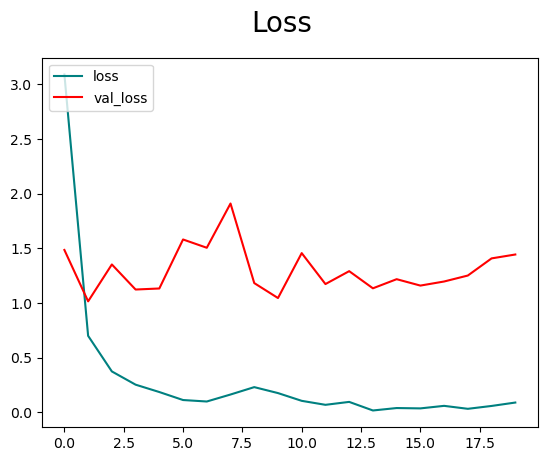

In [83]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

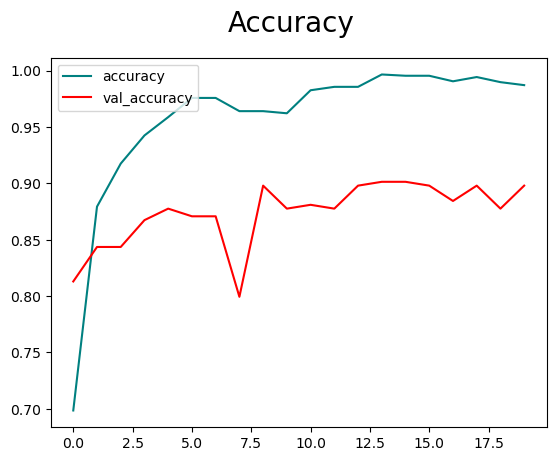

In [84]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [104]:
a = modelvgg.evaluate(validation_dataset)
print("loss: "+ str(a[0]))
print("accuracy: "+ str(a[1]))


50/50 [==============================] - 4s 69ms/step - loss: 4.6117 - acc: 0.7513
loss: 4.6116862297058105
accuracy: 0.7512690424919128
